In [1]:
cd "/suphys/aloe8475"


/suphys/aloe8475


In [2]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [3]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

#warnings.filterwarnings('ignore')

In [4]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [5]:
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# portrait_divergence.py
# Jim Bagrow
# Last Modified: 2018-04-24

import sys, os
import tempfile
import argparse
from collections import Counter
import numpy as np
import networkx as nx
from scipy.stats import entropy


def portrait_cpp(graph, fname=None, keepfile=False):
    """Compute and generate portrait of graph using compiled B_matrix
    executable.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes in shell i
    """
    # file to save to:
    f = fname
    if fname is None:
        f = next(tempfile._get_candidate_names())
    
    # make sure nodes are 0,...,N-1 integers:
    graph = nx.convert_node_labels_to_integers(graph)
    
    # write edgelist:
    nx.write_edgelist(graph, f+".edgelist", data=False)
    
    # make B-matrix:
    os.system("./B_matrix {}.edgelist {}.Bmat > /dev/null".format(f, f))
    portrait = np.loadtxt("{}.Bmat".format(f))
    
    # clean up:
    if not keepfile:
        os.remove(f+".edgelist")
        os.remove(f+".Bmat")
    
    return portrait


def portrait_py(graph):
    """Return matrix B where B[i,j] is the number of starting nodes in graph
    with j nodes in shell i.
    
    If this function is too slow, consider portrait_cpp() instead.
    """
    dia = 500 #nx.diameter(graph)
    N = graph.number_of_nodes()
    # B indices are 0...dia x 0...N-1:
    B = np.zeros((dia+1,N)) 
    
    max_path = 1
    adj = graph.adj
    for starting_node in graph.nodes():
        nodes_visited = {starting_node:0}
        search_queue = [starting_node]
        d = 1
        while search_queue:
            next_depth = []
            extend = next_depth.extend
            for n in search_queue:
                l = [i for i in adj[n] if i not in nodes_visited] 
                extend(l)
                for j in l:
                    nodes_visited[j] = d
            search_queue = next_depth
            d += 1
            
        node_distances = nodes_visited.values()
        max_node_distances = max(node_distances)
        
        curr_max_path = max_node_distances
        if curr_max_path > max_path:
            max_path = curr_max_path
        
        # build individual distribution:
        dict_distribution = dict.fromkeys(node_distances, 0)
        for d in node_distances:
            dict_distribution[d] += 1
        # add individual distribution to matrix:
        for shell,count in dict_distribution.items():
            B[shell][count] += 1
        
        # HACK: count starting nodes that have zero nodes in farther shells
        max_shell = dia
        while max_shell > max_node_distances:
            B[max_shell][0] += 1
            max_shell -= 1
    
    return B[:max_path+1,:]


portrait = portrait_py
#portrait = portrait_cpp


def weighted_portrait(G, paths=None, binedges=None):
    """Compute weighted portrait of G, using Dijkstra's algorithm for finding
    shortest paths. G is a networkx object.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes at distance d_i <  d < d_{i+1}.
    """
    # all pairs path lengths
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(G))
    
    if binedges is None:
        unique_path_lengths  = _get_unique_path_lengths(G, paths=paths)
        sampled_path_lengths = np.percentile(unique_path_lengths, np.arange(0, 101, 1))
    else:
        sampled_path_lengths = binedges
    UPL = np.array(sampled_path_lengths)
    
    l_s_v = []
    for i,(s,dist_dict) in enumerate(paths):
        distances = np.array(list(dist_dict.values()))
        s_v,e = np.histogram(distances, bins=UPL)
        l_s_v.append(s_v)
    M = np.array(l_s_v)
    
    B = np.zeros((len(UPL)-1, G.number_of_nodes()+1))
    for i in range(len(UPL)-1):
        col = M[:,i] # ith col = numbers of nodes at d_i <= distance < d_i+1
        for n,c in Counter(col).items():
            B[i,n] += c
    
    return B


def _get_unique_path_lengths(graph, paths=None):
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(graph))

    unique_path_lengths = set()
    for starting_node,dist_dict in paths:
        unique_path_lengths |= set(dist_dict.values())
    unique_path_lengths = sorted(list(unique_path_lengths))
    return unique_path_lengths


def pad_portraits_to_same_size(B1,B2):
    """Make sure that two matrices are padded with zeros and/or trimmed of
    zeros to be the same dimensions.
    """
    ns,ms = B1.shape
    nl,ml = B2.shape
    
    # Bmats have N columns, find last *occupied* column and trim both down:
    lastcol1 = max(np.nonzero(B1)[1])
    lastcol2 = max(np.nonzero(B2)[1])
    lastcol = max(lastcol1,lastcol2)
    B1 = B1[:,:lastcol+1]
    B2 = B2[:,:lastcol+1]
    
    BigB1 = np.zeros((max(ns,nl), lastcol+1))
    BigB2 = np.zeros((max(ns,nl), lastcol+1))
    
    BigB1[:B1.shape[0],:B1.shape[1]] = B1
    BigB2[:B2.shape[0],:B2.shape[1]] = B2
    
    return BigB1, BigB2


def _graph_or_portrait(X):
    """Check if X is a nx (di)graph. If it is, get its portrait. Otherwise
    assume it's a portrait and just return it.
    """
    if isinstance(X, (nx.Graph, nx.DiGraph)):
        return portrait(X)
    return X


def portrait_divergence(G, H):
    """Compute the network portrait divergence between graphs G and H."""
    
    BG = _graph_or_portrait(G)
    BH = _graph_or_portrait(H)
    BG, BH = pad_portraits_to_same_size(BG,BH)
    
    L, K = BG.shape
    V = np.tile(np.arange(K),(L,1))
    
    XG = BG*V / (BG*V).sum()
    XH = BH*V / (BH*V).sum()
    
    # flatten distribution matrices as arrays:
    P = XG.ravel()
    Q = XH.ravel()
    
    # lastly, get JSD:
    M = 0.5*(P+Q)
    KLDpm = entropy(P, M, base=2)
    KLDqm = entropy(Q, M, base=2)
    JSDpq = 0.5*(KLDpm + KLDqm)
    
    return JSDpq


def portrait_divergence_weighted(G,H, bins=None, binedges=None):
    """Network portrait divergence between two weighted graphs.
    
    bins = width of bins in percentiles
    binedges = vector of bin edges
    bins and binedges are mutually exclusive
    """
    
    # get joint binning:
    paths_G = list(nx.all_pairs_dijkstra_path_length(G))
    paths_H = list(nx.all_pairs_dijkstra_path_length(H))
    
    # get bin_edges in common for G and H:
    if binedges is None:
        if bins is None:
            bins = 1
        UPL_G = set(_get_unique_path_lengths(G, paths=paths_G))
        UPL_H = set(_get_unique_path_lengths(H, paths=paths_H))
        unique_path_lengths = sorted(list(UPL_G | UPL_H))
        binedges = np.percentile(unique_path_lengths, np.arange(0, 101, bins))
    
    # get weighted portraits:
    BG = weighted_portrait(G, paths=paths_G, binedges=binedges)
    BH = weighted_portrait(H, paths=paths_H, binedges=binedges)
    
    return portrait_divergence(BG, BH)

In [7]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [8]:
name='networks_LinearTransformation.pkl'
print('Loading Networks')
file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
[ASN300] = pickle.load(file)


Loading Networks


In [9]:
#Calculate nodesList
nodesList=[[None]*10 for i in range(len(ASN300))]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])): #for each network:
        if len(ASN300[i][j]['G']) >= 250:
            nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
        elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
            nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
            nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
            nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)

In [10]:
ASNaccuracy=[[[None]*len(ASN300[0]) for j in range(len(ASN300))] for i in range(len(nodesList[0][-1]))]


for i in range(len(ASN300)): #for each parameter
    temp=[]
    for j in range(len(ASN300[i])): # for each network
        for k in range(len(ASN300[i][j]['Accuracy']['Linear Transformation'])):
            temp=ASN300[i][j]['Accuracy']['Linear Transformation'][k]
            if k == 0:
                ASNaccuracy[k][i][j]=temp
            elif k == 1:
                ASNaccuracy[k][i][j]=temp
            elif k == 2:
                ASNaccuracy[k][i][j]=temp
            elif k == 3:
                ASNaccuracy[k][i][j]=temp
            elif k == 4:
                ASNaccuracy[k][i][j]=temp
            elif k == 5:
                ASNaccuracy[k][i][j]=temp
                
#Find top 50 accuracy and bottom 50 accuracy networks
count=0
accuracy=[None]*300
for i in range(len(ASNaccuracy[-1])):
    for j in range(len(ASNaccuracy[-1][i])):
        accuracy[count]=ASNaccuracy[-1][i][j]
        count=count+1

idx_acc=np.argsort(accuracy)
accuracy2=np.sort(accuracy)
min_idx_acc=idx_acc[0:50]
min_accuracy=accuracy2[0:50]
max_idx_acc=idx_acc[-50:]
max_accuracy=accuracy2[-50:]

MaxAcc=[]        
for i in range(len(max_idx_acc)):
    if max_idx_acc[i] >= 100: 
        MaxAcc.append([int(float(max_idx_acc[i])/10),list(map(int, str(max_idx_acc[i])))[-1]])
    elif max_idx_acc[i] <10: 
        MaxAcc.append([0, list(map(int, str(max_idx_acc[i])))[-1]])
    else:
        MaxAcc.append(list(map(int, str(max_idx_acc[i]))))

MinAcc=[]        
for i in range(len(min_idx_acc)):
    if min_idx_acc[i] >= 100: 
        MinAcc.append([int(float(min_idx_acc[i])/10),list(map(int, str(min_idx_acc[i])))[-1]])
    elif min_idx_acc[i] <10: 
        MinAcc.append([0, list(map(int, str(min_idx_acc[i])))[-1]])
    else:
        MinAcc.append(list(map(int, str(min_idx_acc[i]))))
#3 Plot Networks on Graph:


In [16]:
#Sort by Modularity
qMax=[None]*len(MaxAcc)
qMin=[None]*len(MinAcc)
#Order Networks by Community_Louvain
for i in tqdm(range(len(MaxAcc))):
    [a,qMax[i]]=nct.community_louvain(ASN300[MaxAcc[i][0]][MaxAcc[i][1]]['adj_matrix'])
    [b,qMin[i]]=nct.community_louvain(ASN300[MinAcc[i][0]][MinAcc[i][1]]['adj_matrix'])

In [17]:
idxMax=np.argsort(qMax)
idxMin=np.argsort(qMin)

In [18]:
sortedMaxAcc=[MaxAcc[item] for item in idxMax]
sortedMinAcc=[MinAcc[item] for item in idxMin]

In [19]:
initMaxMin=[]
initMaxMax=[]
initMinMin=[]
for i in tqdm(range(len(sortedMaxAcc))):
    for j in range(len(sortedMinAcc)):
        initMaxMin.append(inputPacker(portrait_divergence,ASN300[sortedMaxAcc[i][0]][sortedMaxAcc[i][1]]['G'],ASN300[sortedMinAcc[j][0]][sortedMinAcc[j][1]]['G']))
for i in tqdm(range(len(MaxAcc))):
    for j in range(len(MaxAcc)):
        initMaxMax.append(inputPacker(portrait_divergence,ASN300[sortedMaxAcc[i][0]][sortedMaxAcc[i][1]]['G'],ASN300[sortedMaxAcc[j][0]][sortedMaxAcc[j][1]]['G']))
for i in tqdm(range(len(MinAcc))):
    for j in range(len(MinAcc)):
        initMinMin.append(inputPacker(portrait_divergence,ASN300[sortedMinAcc[i][0]][sortedMinAcc[i][1]]['G'],ASN300[sortedMinAcc[j][0]][sortedMinAcc[j][1]]['G']))

In [20]:
divergenceMaxMin=para_run(portrait_divergence,initMaxMin,nCPU=16)
divergenceMaxMax=para_run(portrait_divergence,initMaxMax,nCPU=16)
divergenceMinMin=para_run(portrait_divergence,initMinMin,nCPU=16)

In [21]:
divergenceMaxMin=np.reshape(divergenceMaxMin,(50,50))
divergenceMaxMax=np.reshape(divergenceMaxMax,(50,50))
divergenceMinMin=np.reshape(divergenceMinMin,(50,50))

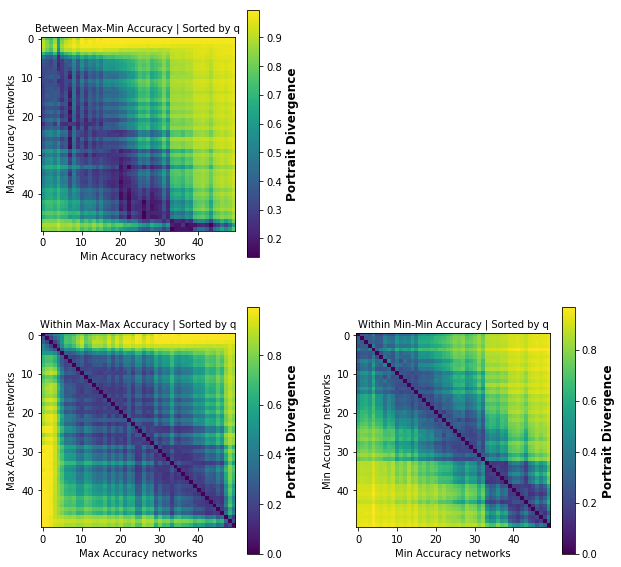

In [22]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=.3)
# fig.subplots_adjust(hspace=.3)
ax=[None]*3
ax[0]=fig.add_subplot(2,2,1)
ax[0].set_title('Between Max-Min Accuracy | Sorted by q',fontsize=10)
plt.imshow(divergenceMaxMin)
plt.xlabel('Min Accuracy networks')
plt.ylabel('Max Accuracy networks')
cb=plt.colorbar()
cb.set_label(label='Portrait Divergence', size='large', weight='bold')

ax[1]=fig.add_subplot(2,2,3)
ax[1].set_title('Within Max-Max Accuracy | Sorted by q',fontsize=10)
plt.imshow(divergenceMaxMax)
plt.xlabel('Max Accuracy networks')
plt.ylabel('Max Accuracy networks')
cb=plt.colorbar()
cb.set_label(label='Portrait Divergence', size='large', weight='bold')

ax[2]=fig.add_subplot(2,2,4)
ax[2].set_title('Within Min-Min Accuracy | Sorted by q',fontsize=10)
plt.imshow(divergenceMinMin)
plt.xlabel('Min Accuracy networks')
plt.ylabel('Min Accuracy networks')
cb=plt.colorbar()
cb.set_label(label='Portrait Divergence', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/50 Min_Max Portrait Divergence Network Comparisons - Sorted by Modularity',dpi=600)

In [23]:
accDiffMax=[]
accDiffMin=[]
accDiffMaxMin=[]
for i in range(len(sortedMaxAcc)):
    for j in range(len(sortedMaxAcc)):
        accDiffMax.append(abs(np.max(ASN300[sortedMaxAcc[i][0]][sortedMaxAcc[i][1]]['Accuracy']['Linear Transformation'])-np.max(ASN300[sortedMaxAcc[j][0]][sortedMaxAcc[j][1]]['Accuracy']['Linear Transformation'])))
        accDiffMin.append(abs(np.max(ASN300[sortedMinAcc[i][0]][sortedMinAcc[i][1]]['Accuracy']['Linear Transformation'])-np.max(ASN300[sortedMinAcc[j][0]][sortedMinAcc[j][1]]['Accuracy']['Linear Transformation'])))
        accDiffMaxMin.append(abs(np.max(ASN300[sortedMaxAcc[i][0]][sortedMaxAcc[i][1]]['Accuracy']['Linear Transformation'])-np.max(ASN300[sortedMinAcc[j][0]][sortedMinAcc[j][1]]['Accuracy']['Linear Transformation'])))

In [24]:
accDiffMaxMin=np.reshape(accDiffMaxMin,(50,50))
accDiffMin=np.reshape(accDiffMin,(50,50))
accDiffMax=np.reshape(accDiffMax,(50,50))

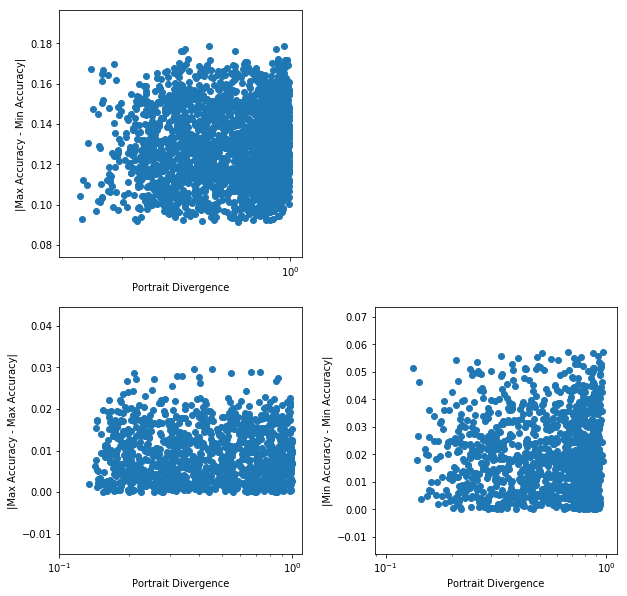

In [25]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=.3)
ax = fig.add_subplot(2, 2, 1)
plt.scatter(divergenceMaxMin,accDiffMaxMin)
# cb=plt.colorbar()
plt.ylabel('|Max Accuracy - Min Accuracy|')
plt.xlabel('Portrait Divergence')
ax.set_xscale('log')
# cb.set_label(label='Modularity(q)', size='large', weight='bold')

ax = fig.add_subplot(2, 2, 3)

plt.scatter(np.triu(divergenceMaxMax),np.triu(accDiffMax))
# cb=plt.colorbar()
plt.ylabel('|Max Accuracy - Max Accuracy|')
plt.xlabel('Portrait Divergence')
ax.set_xscale('log')
ax.set_xlim([10e-2, 1.1])

# cb.set_label(label='Modularity(q)', size='large', weight='bold')
ax = fig.add_subplot(2, 2, 4)

plt.scatter(np.triu(divergenceMinMin),np.triu(accDiffMin))
# cb=plt.colorbar()
plt.ylabel('|Min Accuracy - Min Accuracy|')
plt.xlabel('Portrait Divergence')
ax.set_xscale('log')

# cb.set_label(label='Modularity(q)', size='large', weight='bold')

In [11]:
# SORT 50 x 50 / 300 x 300 BY ACCURACY:
asn_acc=[]
asn_mod=[]
asn_avgDeg=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        degree=np.mean([val for (node, val) in ASN300[i][j]['G'].degree()])
        asn_acc.append(np.nanmax(ASN300[i][j]['Accuracy']['Linear Transformation']))
        asn_mod.append(np.nanmax(ASN300[i][j]['Graph Theory']['Modularity Score']))
        asn_avgDeg.append(degree)

In [12]:
acc_sorted=np.sort(asn_acc)
acc_idx=np.argsort(asn_acc)

In [13]:
accIDX=[]        
for i in range(len(acc_idx)):
    if acc_idx[i] >= 100: 
        accIDX.append([int(float(acc_idx[i])/10),list(map(int, str(acc_idx[i])))[-1]])
    elif acc_idx[i] <10: 
        accIDX.append([0, list(map(int, str(acc_idx[i])))[-1]])
    else:
        accIDX.append(list(map(int, str(acc_idx[i]))))

In [14]:
initAcc=[]
for i in tqdm(range(len(acc_sorted))):
    for j in range(len(acc_sorted)):
        initAcc.append(inputPacker(portrait_divergence,ASN300[accIDX[i][0]][accIDX[i][1]]['G'],ASN300[accIDX[j][0]][accIDX[j][1]]['G']))

In [21]:
divergenceAcc=para_run(portrait_divergence,initAcc,nCPU=10)

In [22]:
divergenceAcc=np.reshape(divergenceAcc,(300,300))


In [ ]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/'
compressed_pickle(divergenceAcc,'PortraitDivergenceASN300')

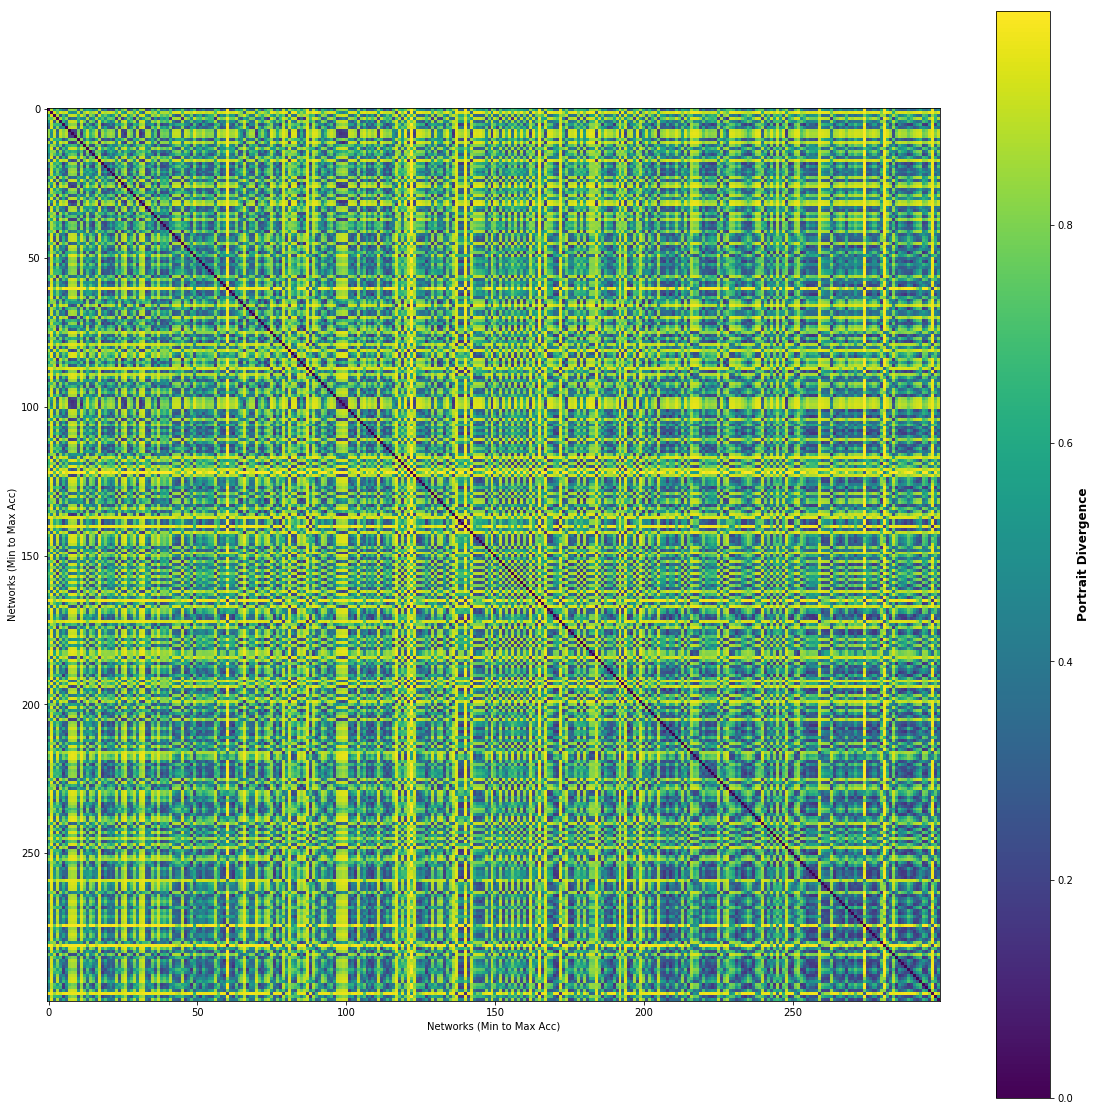

In [23]:
fig=plt.figure(figsize=(20,20))
fig.subplots_adjust(wspace=.3)
# fig.subplots_adjust(hspace=.3)
plt.imshow(divergenceAcc)
plt.xlabel('Networks (Min to Max Acc)')
plt.ylabel('Networks (Min to Max Acc)')
cb=plt.colorbar()
cb.set_label(label='Portrait Divergence', size='large', weight='bold')

plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/All Networks Portrait Divergence Network Comparisons - Sorted by Accuracy',dpi=300)

## Multi Dimensional Scaling

In [24]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
divergence_transformed = embedding.fit_transform(divergenceAcc)

<IPython.core.display.Javascript object>


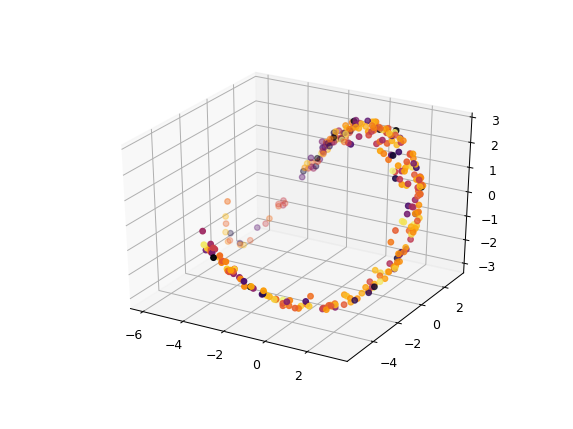

In [28]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(divergence_transformed[:,0],divergence_transformed[:,1],divergence_transformed[:,2],cmap=plt.cm.inferno,c=accuracy)

In [29]:
acc_idx=np.array(range(300))
mc_idx=np.array(range(300))

In [40]:
color=[None]*len(accuracy)
for i in range(len(accuracy)):
    if accuracy[i] < 0.71:
        color[i]='b'
#     elif accuracy[i] >= 0.77 and accuracy[i] < 0.82:
#         color[i]='g'
    elif accuracy[i] > 0.837:
        color[i]='r'
    else:
        color[i]='white'
mask= acc_idx[np.array(accuracy) < 0.71]
mask2= acc_idx[np.array(accuracy) > 0.837]
masks=np.hstack((mask,mask2))

In [41]:
mask

array([  0,  80,  90, 101, 104, 108, 114, 126, 146, 148, 153, 164, 165,
       166, 171, 173, 177, 179, 185, 191, 194, 198, 225, 227])

In [42]:
color=np.array(color)

In [53]:
cd '/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity'

/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity


<IPython.core.display.Javascript object>


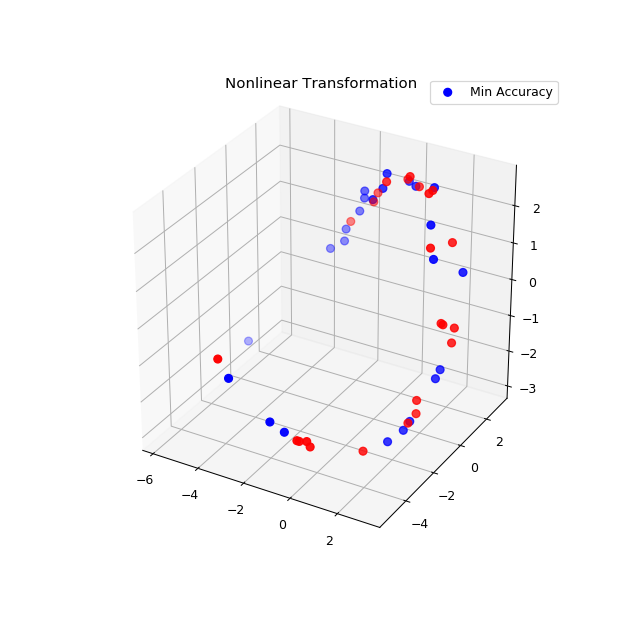

In [55]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
plt.title('Nonlinear Transformation',pad=20)
ax.scatter(divergence_transformed[masks,0],divergence_transformed[masks,1],divergence_transformed[masks,2],cmap=plt.cm.inferno,c=color[masks],s=40)#
plt.legend({'Min Accuracy','Max Accuracy'})

plt.savefig('MultiDimensionalScaling - Portrait Divergence Nonlinear Transform.png')

# Beta Sweep

In [8]:
name= r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/BetaSweep_Networks'
Networks=decompress_pickle(name)  

In [10]:
numNodes=300
BetaVals=np.linspace(0.1,1,10)
avgDeg=[2,4,8,16,32]
numNetworks=50


In [11]:
BetaGraphs=[[[None]*numNetworks for i in range(len(avgDeg))] for j in range(len(BetaVals))]
for i in range(len(BetaVals)):     
    name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/BetaSweep/WS_BetaGraphs_' +str(i)
    print('Loading WS')
    file = open(name, 'rb')
    [BetaGraphs[i]] = pickle.load(file)

Loading WS
Loading WS
Loading WS
Loading WS
Loading WS
Loading WS
Loading WS
Loading WS
Loading WS
Loading WS


In [13]:
g=[]
for i in range(len(Networks)):
    for j in range(len(Networks[i])):
        for k in range(len(Networks[i][j])):
            g.append(BetaGraphs[i][j][k])

In [14]:
init=[]
for i in tqdm(range(len(g))):
    for j in tqdm(range(len(g))):
        init.append(inputPacker(portrait_divergence,g[i],g[j]))

In [15]:
divergenceWS=para_run(portrait_divergence,init,nCPU=10)

Process ForkPoolWorker-8:
2020-07-17 14:10:40,009:ERROR:Internal Python error in the inspect module.
Below is the traceback from this internal error.

2020-07-17 14:10:40,102:INFO:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/pool.py", line 733, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/import/silo2/aloe8475/Documents/edamame/edamame/utils/tools.py", line 59, in para_run
    disable = disable_tqdm))
  File "/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 221, in __iter__
    for obj in super(tqdm_notebook, self).__iter__(*args, **kwargs):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py", line 1022, in __iter__
    for obj in iterable:
  File "/import/silo2/aloe8475/Documents/edamame/edamame/utils/tools.py", line 36, in <genexpr>
    return (item for chunk in result for item in chunk)
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/pool.py", line 737, in next
    self._cond.wait(tim

TypeError: can only concatenate str (not "list") to str

In [ ]:
divergenceWS=np.reshape(divergenceWS,(2500,2500))


In [ ]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/'
compressed_pickle(divergence,'PortraitDivergenceBetaSweep')